# Preliminary Items

References: https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

In [31]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
import 	tensorflow 	as 		tf
from 	tensorflow 	import 	keras

## Mount Google Drive 

In [32]:
currentWorkingDir = !pwd
defaultWorkingDir = "/content"

if ( currentWorkingDir[0] == defaultWorkingDir ):
  from google.colab import drive

  drive.mount('/content/drive')
      
  %cd "/content/drive/My Drive/Colab Notebooks/stock_portfolio"
else:
  print("Currenting running app from: ")
  !pwd

Currenting running app from: 
/content/drive/My Drive/Colab Notebooks/stock_portfolio


# Scaling and Feature Selection

In [33]:
s = "CCC"

In [34]:
df_m = pd.read_csv("prices_sentiment_"+s+".csv")

In [35]:
# Replace nan with zero
df_m = df_m.fillna(0)

# create index with date
df_m = df_m.set_index("Date")


In [36]:
# Indexing Batches
train_df = df_m.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Symbol,Close_Price,Volume_non_block,Today_High,Today_Low,no_days_not_traded_since_last_traded,sentiment,is_regarding_financial_report,is_sold_pur_shares
0,CCC,20.15,10000.0,20.44,20.00,0,0.0,0.0,0.0
1,CCC,19.50,5019013.0,20.44,19.06,0,0.0,0.0,0.0
2,CCC,20.24,163870.0,21.00,19.60,0,0.0,0.0,0.0
3,CCC,20.87,90670.0,26.50,20.50,0,0.0,0.0,0.0
4,CCC,22.03,90201.0,25.00,21.05,0,0.0,0.0,0.0


In [37]:
# List of considered Features
FEATURES = ['Today_High', 
            'Today_Low', 
            'Close_Price', 
            'Volume_non_block'
            #"no_days_not_traded_since_last_traded", 
            #"sentiment", 
            #"is_regarding_financial_report", 
            #"is_sold_pur_shares"
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close_Price']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Today_High', 'Today_Low', 'Close_Price', 'Volume_non_block']


,Today_High,Today_Low,Close_Price,Volume_non_block,Prediction
1210,62.00,60.00,61.551857,3124.0,61.551857
1211,61.55,60.00,60.519899,4053.0,60.519899
1212,61.50,58.51,60.008883,257378.0,60.008883
1213,62.00,60.00,60.251705,68927.0,60.251705
1214,64.00,60.00,62.807004,137215.0,62.807004


## Scaling

In [54]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]
print(nrows)

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
print(data_filtered.tail(5))
print(np_data_unscaled[0])
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close_Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

1215
      Today_High  Today_Low  Close_Price  Volume_non_block
1210       62.00      60.00    61.551857            3124.0
1211       61.55      60.00    60.519899            4053.0
1212       61.50      58.51    60.008883          257378.0
1213       62.00      60.00    60.251705           68927.0
1214       64.00      60.00    62.807004          137215.0
[   20.44    20.      20.15 10000.  ]
(1215, 4)


# Transforming the Data

In [50]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close_Price")
print(index_Close)

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
print(train_data_len)
# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
print(train_data[0][0])
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

1
972
0.005500000000000005
(922, 50, 4) (922,)
(243, 50, 4) (243,)
0.022727272727272763
0.022727272727272763


# Model Training

In [22]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

200 50 4


In [23]:
# Training the model
epochs = 25
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/25
58/58 [==============================] - 15s 209ms/step - loss: 0.0291 - val_loss: 0.0040
Epoch 2/25
58/58 [==============================] - 11s 188ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 3/25
58/58 [==============================] - 11s 191ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 4/25
58/58 [==============================] - 11s 192ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 5/25
58/58 [==============================] - 11s 190ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/25
58/58 [==============================] - 11s 193ms/step - loss: 8.9606e-04 - val_loss: 0.0034
Epoch 7/25
58/58 [==============================] - 11s 194ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 8/25
58/58 [==============================] - 12s 202ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 9/25
58/58 [==============================] - 11s 198ms/step - loss: 9.2337e-04 - val_loss: 0.0023
Epoch 10/25
58/58 [==============================] - 11s 194ms/step - loss: 9.1325e

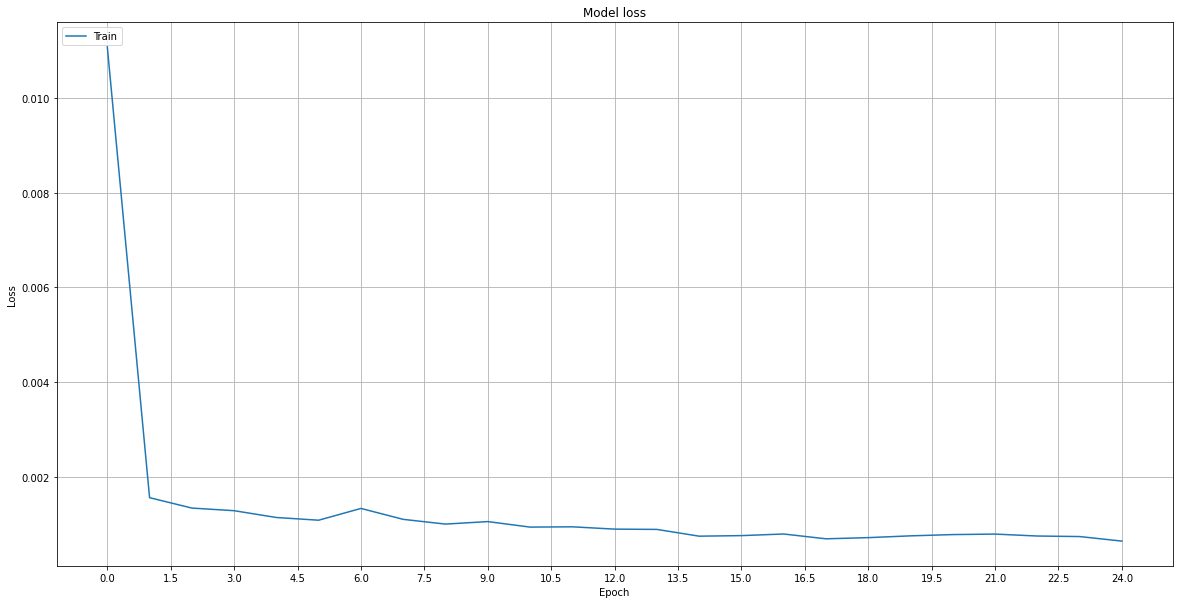

In [25]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Evaluate Model Performance

In [26]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print(f'Median Absolute Error (MedAE): {np.round(MEDAE, 2)}')

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 1.88
Median Absolute Error (MedAE): 1.35
Mean Squared Error (MSE): 8.13
Root Mean Squared Error (RMSE): 2.85
Mean Absolute Percentage Error (MAPE): 3.93 %
Median Absolute Percentage Error (MDAPE): 2.77 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


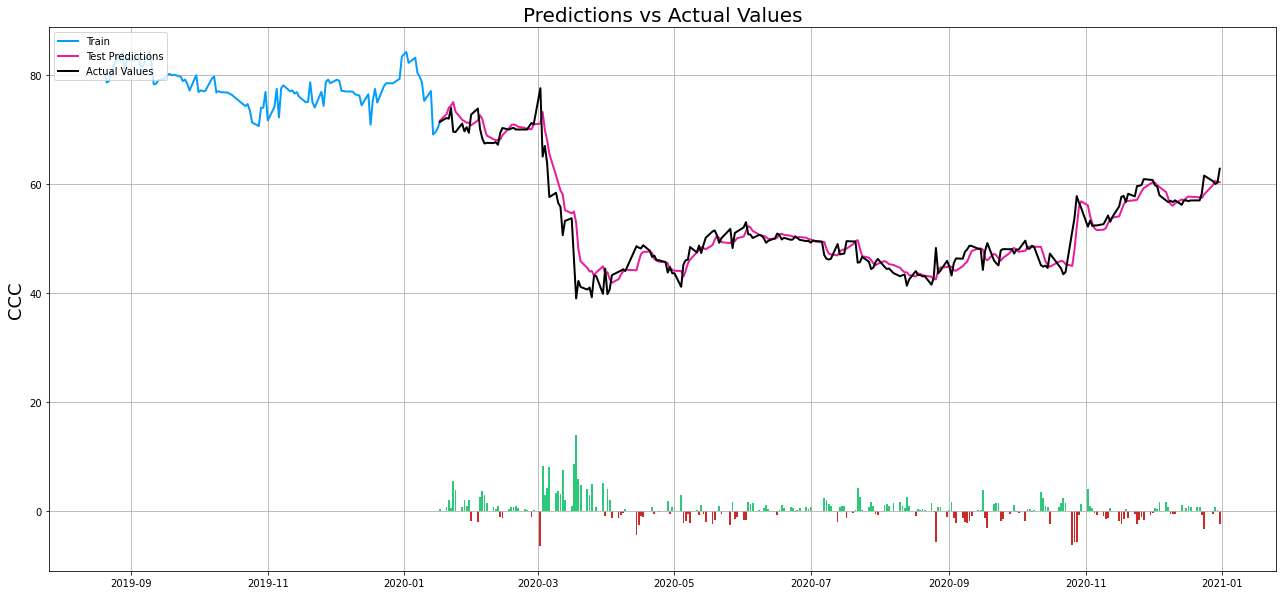

In [30]:
# The date from which on the date is displayed

display_start_date = pd.Timestamp(year=2021,month=1,day=1) - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close_Price"], True)

valid['Date'] = pd.to_datetime(valid.Date,infer_datetime_format=True)
train['Date'] = pd.to_datetime(train.Date,infer_datetime_format=True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] >= display_start_date]
train = train[train['Date'] >= display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close_Price"]]
xv = valid['Date']; yv = valid[["Close_Price", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(s, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close_Price"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.savefig( symbol+'.png', bbox_inches='tight')
plt.show()



# Predict Next Day's Price

In [34]:
model = tf.keras.models.load_model("mv_CCC_4_25_lstm_model.h5")

In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close_Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1215, 8)


In [28]:
df_temp = df_m[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
#price_today = np.round(new_df['Close_Price'][-1], 2)
price_today = np.round(new_df["Close_Price"].values[-1],2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {s} at 31-Dec-2020 was {price_today}')
print(f'The predicted close price is {predicted_price:.2f} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for CCC at 31-Dec-2020 was 62.81
The predicted close price is 61.02 (-2.93%)


In [35]:
df_temp = df_m[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
#price_today = np.round(new_df['Close_Price'][-1], 2)
price_today = np.round(new_df["Close_Price"].values[-1],2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {s} at 31-Dec-2020 was {price_today}')
print(f'The predicted close price is {predicted_price:.2f} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for CCC at 31-Dec-2020 was 62.81
The predicted close price is 19.70 (-218.83%)


# Plotly

In [ ]:
!pip install plotly

In [ ]:
import numpy as np
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
print (__version__) # requires version >= 1.9.0

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

4.4.1


In [ ]:
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.tools as tls

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 2.8 MB/s 


In [ ]:
plotly_fig = tls.mpl_to_plotly(fig)
plotly.offline.plot(plotly_fig, filename="plotly version of an mpl figure")

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `plotly version of an mpl figure` didn't end with .html. Adding .html to the end of your file.



'plotly version of an mpl figure.html'